In [31]:
import copy
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import keras
from keras.layers import Dense, Flatten
from sklearn.metrics import roc_curve
import tensorflow as tf
import os

# Loading data

In [2]:
# Parameters
fs = 44100                  # Hz, sampling frequency
f_size = 512                # Frame size
h_size = int(f_size/2)      # Hop size
supra_frame_duration = 0.5  # seconds
frame_num_gl = round(supra_frame_duration / (h_size/fs))
dir_HC = 'wav'+ os.sep + 'HC' + os.sep
dir_ALS = 'wav' + os.sep + 'ALS' + os.sep
directory_ALS = os.listdir(dir_ALS)
directory_HC = os.listdir(dir_HC)

In [19]:
X = np.zeros((20000,h_size,frame_num_gl))   # data
y = np.zeros((20000,1))                     # labels
X_global_index = 0
X_ids = list([])                            # IDs of the speakers
# Cycle for HC (helthy controls)
for i in range(len(directory_HC)):
    if directory_HC[i][4:]=='a.dat':
        fileName = dir_HC + directory_HC[i]
        

        X_stft = np.fromfile(dir_HC + directory_HC[i], dtype=np.half)
        X_stft = np.reshape(X_stft,(h_size, np.floor(len(X_stft)/h_size).astype(int)))
        
        # plt.subplots(dpi=150)
        # plt.pcolor(X_stft,shading='flat',cmap='jet')
        # plt.xlabel('Номер фрейма')
        # plt.ylabel('$\log(|X(k,m)|)$')
        # plt.show()

#       #Запись фрагметов спектра в трехмерный массив 
        frame_num = X_stft.shape[1]
        N_supra_frames = frame_num - frame_num_gl + 1

        # generator comprehension
        gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
        for n in gen_range:
            X[X_global_index,:,:] = X_stft[:,n:n+frame_num_gl]
            X_ids.append(int(directory_HC[i][0:3]))
            y[X_global_index] = 0
            X_global_index = X_global_index +1
    
# Cycle for ALS (pathology)
for i in range(len(directory_ALS)):
    if directory_ALS[i][4:]=='a.dat':
        fileName = dir_ALS + directory_ALS[i]        

        X_stft = np.fromfile(dir_HC + directory_HC[i], dtype=np.half)
        X_stft = np.reshape(X_stft,(h_size, np.floor(len(X_stft)/h_size).astype(int)))

#       #Запись фрагметов спектра в трехмерный массив
        frame_num = X_stft.shape[1]
        N_supra_frames = frame_num - frame_num_gl + 1

        # generator comprehension
        gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
        for n in gen_range:
            X[X_global_index,:,:] = X_stft[:,n:n+frame_num_gl]
            X_ids.append(int(directory_ALS[i][0:3]))
            y[X_global_index] = 1
            X_global_index = X_global_index + 1
            
inds_to_delete = np.array(range(y.shape[0]))>=X_global_index
y = np.delete(y,inds_to_delete)
X = np.delete(X,inds_to_delete, axis=0)

# Data normalization

In [17]:
X_mean = tf.reduce_mean(X, axis = 0).numpy()
X_zero_mean = X - X_mean
X_sd   = np.sqrt(tf.reduce_mean((X_zero_mean)**2, axis = 0).numpy())
# X_sd = np.sqrt(X_sd.reshape(X.shape[0],1))

print('mean(X[2,:]) = ', X_mean[0])
print('SD(X[2,:]) = ', X_sd[0])

# X_normalized = keras.layers.UnitNormalization(axis=1)(X)
# X_normalized = X_normalized.numpy()

X_normalized = (X_zero_mean)/X_sd

# print('mean(X_normalized[2,:]) = ', np.mean(X_normalized[:,:,2]))
# print('SD(X_normalized[2,:]) = ', np.std(X_normalized[:,:,0]))

mean(X[2,:]) =  [-1.7553827  -1.77281972 -1.75577099 -1.77476957 -1.75716288 -1.77525662
 -1.7582519  -1.77597149 -1.75939042 -1.77673691 -1.76143172 -1.77735042
 -1.76309312 -1.77906228 -1.76699215 -1.77926183 -1.76785756 -1.7814342
 -1.77011437 -1.78338946 -1.7717327  -1.78350617 -1.77205268 -1.78602843
 -1.77258215 -1.78712521 -1.77540061 -1.78972791 -1.77607469 -1.79255056
 -1.77887576 -1.79483959 -1.77957343 -1.79611197 -1.78063027 -1.797258
 -1.7827308  -1.79789673 -1.78367079 -1.79802052 -1.78516746 -1.80045473
 -1.7854992  -1.80205756 -1.78490239 -1.80220378 -1.78579832 -1.80380443
 -1.7871345  -1.80412113 -1.78713468 -1.80397074 -1.78797451 -1.80600406
 -1.79057066 -1.80753748 -1.79215158 -1.8107607  -1.79162725 -1.81323595
 -1.79361319 -1.81360907 -1.79631942 -1.81524719 -1.79763498 -1.81640465
 -1.79937824 -1.81745096 -1.80083541 -1.81819676 -1.80155791 -1.81938907
 -1.80193823 -1.82018971 -1.80215787 -1.82023736 -1.80277761 -1.82267408
 -1.80492913 -1.82269513 -1.80496604 -

# Train/Test sets

In [64]:
test_subjects_ids = (25, 26, 32, 61, 62, 107) # 3 -> ALS;  3-> HC

test_inds_in_dataset = (i for i in range(len(X_ids)) if X_ids[i] in test_subjects_ids)
test_inds_in_dataset = list(test_inds_in_dataset)

train_inds_in_dataset = (i for i in range(len(X_ids)) if (X_ids[i] not in test_subjects_ids))
train_inds_in_dataset = list(train_inds_in_dataset)

X_test  = X_normalized[test_inds_in_dataset,:,:]
y_test  = y[test_inds_in_dataset]

X_train = X_normalized[train_inds_in_dataset,:,:]
y_train = y[train_inds_in_dataset]

In [2]:
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

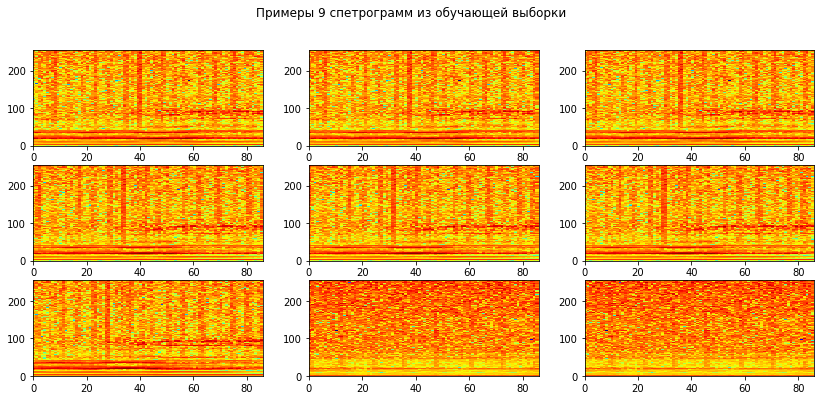

In [22]:
# отображение первых 25 изображений из обучающей выборки
f, a = plt.subplots(3, 3, figsize=(14,6))
f.suptitle('Примеры 9 (нормализованных) спетрограмм из обучающей выборки')
for i in range(9):
    plt.subplot(3,3,i+1)
    # plt.xticks([])
    # plt.yticks([])
    # plt.imshow(X_train[i], cmap='jet')
    plt.pcolor(X_train[i+200], cmap='jet')

plt.show()

In [66]:
model = keras.Sequential([
    Flatten(input_shape=(h_size, X.shape[2])),
    Dense(1, activation='sigmoid',kernel_regularizer=keras.regularizers.L1(0.01),)
])

print(model.summary())      # вывод структуры НС в консоль

model.compile(optimizer='adam',
            #  loss='mean_squared_error',
             loss=keras.losses.BinaryCrossentropy(from_logits=False),
             metrics=['accuracy', keras.metrics.Precision(), 
             keras.metrics.Recall()])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 22016)             0         
                                                                 
 dense_4 (Dense)             (None, 1)                 22017     
                                                                 
Total params: 22,017
Trainable params: 22,017
Non-trainable params: 0
_________________________________________________________________
None


## Train process

In [67]:
# X_tr = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))

epochs_num = 20

hist = model.fit(X_train, y_train, batch_size=100, epochs=epochs_num, validation_split=0.3)

Epoch 1/20
105/105 [==============================] - 3s 17ms/step - loss: 2.1528 - accuracy: 0.6475 - precision_20: 0.3955 - recall_13: 0.5838 - val_loss: 2.4733 - val_accuracy: 0.0963 - val_precision_20: 1.0000 - val_recall_13: 0.0963
Epoch 2/20
105/105 [==============================] - 7s 71ms/step - loss: 0.9571 - accuracy: 0.6987 - precision_20: 0.4527 - recall_13: 0.5651 - val_loss: 1.5533 - val_accuracy: 0.2345 - val_precision_20: 1.0000 - val_recall_13: 0.2345
Epoch 3/20
105/105 [==============================] - 1s 8ms/step - loss: 0.7490 - accuracy: 0.6933 - precision_20: 0.4456 - recall_13: 0.5668 - val_loss: 1.7556 - val_accuracy: 0.1341 - val_precision_20: 1.0000 - val_recall_13: 0.1341
Epoch 4/20
105/105 [==============================] - 1s 13ms/step - loss: 0.7003 - accuracy: 0.7020 - precision_20: 0.4567 - recall_13: 0.5580 - val_loss: 1.6506 - val_accuracy: 0.1598 - val_precision_20: 1.0000 - val_recall_13: 0.1598
Epoch 5/20
105/105 [==============================] -

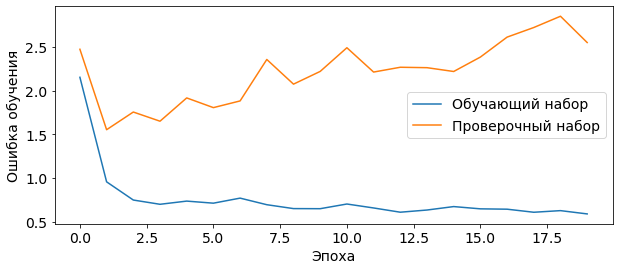

In [68]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

fig, ax = plt.subplots(figsize=(10,4))
plt.rcParams.update({'font.size': 14})
plt.plot(range(epochs_num), train_loss, label='Обучающий набор')
plt.plot(range(epochs_num), val_loss, label='Проверочный набор')
plt.legend()
plt.xlabel('Эпоха')
plt.ylabel('Ошибка обучения')


#Saving results
image_name = f'figures/loss_NN.jpg'
# fig.savefig(image_name, format='jpg', dpi=110, bbox_inches='tight', pad_inches = 0.2)

# Prediction

In [69]:
# model.evaluate(X_test, y_test)

y_est = model.predict(X_test)   # training = False
y_est = np.reshape(y_est,(y_est.shape[0]))
y_est = 1-y_est

81/81 [==============================] - 0s 2ms/step


AUC = 0.818
Prec = 0.815
Recall = 0.581


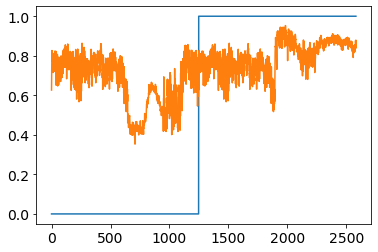

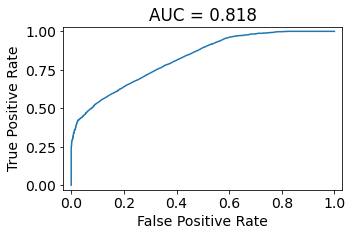

In [70]:
def plot_roc_curve(fpr,tpr,auc): 
  fig,ax = plt.subplots(figsize=(5,3))
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.title(f'AUC = {auc:2.3f}')
  plt.xlim((-0.03, 1.03))
  plt.ylim((-0.03, 1.03))
  return fig

# y_est = np.squeeze(y_est,axis=2)

auc_func = keras.metrics.AUC(thresholds=np.linspace(0,1.0,20))
auc_func.update_state(y_test, y_est)
AUC = auc_func.result().numpy()

fpr, tpr, thresholds = roc_curve (y_test, y_est, pos_label=1.0)    

effectiveness = tpr -fpr
idx = np.argmax(effectiveness)
best_thrs  = thresholds[idx]


prec_func = keras.metrics.Precision(thresholds=best_thrs)
prec_func.update_state(y_test, y_est)
Prec = prec_func.result().numpy()

recall_func = keras.metrics.Recall(thresholds=best_thrs)
recall_func.update_state(y_test, y_est)
Recall = recall_func.result().numpy()

print(f'AUC = {AUC:2.3f}')
print(f'Prec = {Prec:2.3f}')
print(f'Recall = {Recall:2.3f}')

plt.plot(y_test)
plt.plot(y_est)

fig = plot_roc_curve (fpr, tpr, AUC)

plt.show()
# Saving results
# image_name = 'figures/AUC_keras_NN_2_Layers_40_hidden_units_dropout_5_mfcc_frames.jpg'
# fig.savefig(image_name, format='jpg', dpi=140, bbox_inches='tight', pad_inches = 0.2)